<a href="https://colab.research.google.com/github/ladsong/if697-2020.2-data-science/blob/projeto2/Projeto_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Preparando o ambiente

In [34]:
import pandas as pd
import numpy as np
import re
import gc
import warnings
import sys

In [35]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [36]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# /content/gdrive/My Drive/Kaggle é o caminho onde o arquivo kaggle.json está presente do Google Drive
#Mudar o diretorio
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


##Carregando o dataset e processando os dados
No projeto 1, foi adicionado o dump dos dados para que possamos utiliza-los aqui. O objetivo desse projeto é predizer a popularidade de uma música através de suas caracteristicas informadas no subset.

In [37]:
df = pd.read_csv('project1_output.csv')

Observamos que o dataset é grande e assim decidimos utilizar um subset  com o objetivo de diminuir o tempo de experimentação

In [38]:
df = df[:5000]
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
df.dtypes

year                   int64
acousticness         float64
artists_data          object
danceability         float64
duration_ms            int64
energy               float64
explicit               int64
id                    object
instrumentalness     float64
loudness             float64
name                  object
popularity           float64
release_date          object
speechiness          float64
tempo                float64
first_artist          object
artists_by_artist     object
first_genre           object
dtype: object

Tirando colunas desnecessárias, como `artist_data, id, name, release_date, first_artist, artists_by_artist` e `first_genre,` pois só queremos trabalhar com valores numéricos




In [39]:
df = df.select_dtypes(exclude=['object'])

In [40]:
df.columns

Index(['year', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'explicit', 'instrumentalness', 'loudness', 'popularity', 'speechiness',
       'tempo'],
      dtype='object')



###Escolher coluna para predição

In [41]:
target_col = df['popularity']

In [42]:
target_col

0       0.04
1       0.02
2       0.04
3       0.00
4       0.01
        ... 
4995    0.00
4996    0.00
4997    0.00
4998    0.00
4999    0.00
Name: popularity, Length: 5000, dtype: float64

In [43]:
df = df.drop(columns=['popularity'])

##Separando os dados em teste e predição
Para realizacão do treinamento, teste e vaidacão, iremos separa o subset em: 

*   3/5 dos dados para treinamento
*   1/5 dos dados para teste 
*   1/5 dos dados para validacão

Seguindo assim, uma base 60/20/20



In [44]:
def get_x_data():
    # input 
    train, val, test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])
    
    return train, val, test

In [45]:
def get_y_data():
    # output
    train_labels, val_labels, test_labels = (
        np.split(
            target_col, 
            [int(.6*len(target_col)), int(.8*len(target_col))])
    )
    
    return train_labels, val_labels, test_labels

##Escolher os 4 algoritmos para predição

Os algoritmos de predicão que iremos usar são:

*   Regressão Linear
*   Multilayer perceptron
*   Random forests
*   Gradient boost com lightgbm


In [46]:
!pip install mlflow --quiet

In [47]:
!pip install optuna

In [48]:
import mlflow
import mlflow.sklearn

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision
from tensorflow.keras.layers.experimental import preprocessing

import optuna

from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    confusion_matrix,
    classification_report,
    accuracy_score
)
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import lightgbm
from lightgbm import LGBMRegressor

###Função de avaliação das metricas


In [49]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

In [50]:
mlflow.sklearn.autolog()
mlflow.tensorflow.autolog()
mlflow.lightgbm.autolog()

2021/08/17 02:07:01 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of lightgbm. If you encounter errors during autologging, try upgrading / downgrading lightgbm to a supported version, or try upgrading MLflow.


###Regressão Linear

In [51]:
def linear_regression(trial):
    train, test, val = get_x_data()
    train_labels, val_labels, test_labels = get_y_data()
    
    warnings.filterwarnings("ignore")
    np.random.seed(40)

    with mlflow.start_run(run_name="Linear Regression"):
        reg = LinearRegression()
        reg.fit(train, train_labels)

        predictions = reg.predict(val)

        (rmse, mae, r2) = eval_metrics(val_labels, predictions)

        print("Modelo de regressão linear")
        print("  RMSE: %s" % rmse)
        print("  MAE: %s" % mae)
        print("  R2: %s" % r2)

        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("r2", r2)
        
        
        gc.collect()
        
        return rmse

In [52]:
study = optuna.create_study()
study.optimize(linear_regression, n_trials=1)

[I 2021-08-17 02:07:01,171] A new study created in memory with name: no-name-18403bc7-18cc-4800-b3f2-92f4412cb19c


Modelo de regressão linear
  RMSE: 0.13007774724559681
  MAE: 0.08351024898801312
  R2: -0.05721659355374098


[I 2021-08-17 02:07:01,997] Trial 0 finished with value: 0.13007774724559681 and parameters: {}. Best is trial 0 with value: 0.13007774724559681.


###Multilayer Perceptron

In [53]:
def mlp(trial):
    train, test, val = get_x_data()
    train_labels, val_labels, test_labels = get_y_data()
    
    params = {
        "hidden_units": trial.suggest_int("hidden_units", 3, 15),
        "lr": trial.suggest_float("lr", 1e-5, 1e-3, log=True),
        "epochs": trial.suggest_int("epochs", 10, 50)
    }
    
    warnings.filterwarnings("ignore")
    np.random.seed(40)
    
    with mlflow.start_run(run_name="MLP"):
        normalizer = preprocessing.Normalization(axis=-1)
        normalizer.adapt(np.array(train))
        
        mlp_model = tf.keras.Sequential([
            normalizer,
            layers.Dense(units=params["hidden_units"]),
            layers.Dense(units=params["hidden_units"]),
            layers.Dense(units=params["hidden_units"]),
            layers.Dense(units=1),
        ])

        mlp_model.summary()
        
        mlp_model.compile(
            optimizer=tf.optimizers.Adam(learning_rate=params["lr"]),
            loss='mean_squared_error'
        )

        history = mlp_model.fit(
            train, train_labels,
            validation_data=(test, test_labels),
            epochs=params["epochs"]
        )
        
        predictions = mlp_model.predict(val)

        (rmse, mae, r2) = eval_metrics(val_labels, predictions)

        print("MLP model")
        print("  RMSE: %s" % rmse)
        print("  MAE: %s" % mae)
        print("  R2: %s" % r2)

        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("r2", r2)
        mlflow.log_params(trial.params)
        mlflow.set_tags(
            {
                "estimator_name":"MultiLayerPerceptron",
                "estimator_class":"Keras"
            }
        )
        
        tf.keras.backend.clear_session()

        gc.collect()
        
        return rmse

In [54]:

study = optuna.create_study()
study.optimize(mlp, n_trials=10)

[I 2021-08-17 02:07:02,069] A new study created in memory with name: no-name-cd1ce511-d17d-4282-bdf2-6fc9b85034ce


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 10)                21        
_________________________________________________________________
dense (Dense)                (None, 9)                 99        
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 90        
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 90        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 10        
Total params: 310
Trainable params: 289
Non-trainable params: 21
_________________________________________________________________
Epoch 1/20
94/94 [==============================] - 1s 7ms/step - loss: 1.5827 - val_loss: 1.3481
Epoch 2/20
94/94 [=======

[I 2021-08-17 02:07:14,926] Trial 0 finished with value: 0.6462783509935037 and parameters: {'hidden_units': 9, 'lr': 1.6290524753977306e-05, 'epochs': 20}. Best is trial 0 with value: 0.6462783509935037.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 10)                21        
_________________________________________________________________
dense (Dense)                (None, 6)                 66        
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 178
Trainable params: 157
Non-trainable params: 21
_________________________________________________________________
Epoch 1/16
94/94 [==============================] - 1s 3ms/step - loss: 2.7936 - val_loss: 2.8633
Epoch 2/16
94/94 [=======

[I 2021-08-17 02:07:20,374] Trial 1 finished with value: 0.7498166016989934 and parameters: {'hidden_units': 6, 'lr': 3.693862669069487e-05, 'epochs': 16}. Best is trial 0 with value: 0.6462783509935037.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 10)                21        
_________________________________________________________________
dense (Dense)                (None, 13)                143       
_________________________________________________________________
dense_1 (Dense)              (None, 13)                182       
_________________________________________________________________
dense_2 (Dense)              (None, 13)                182       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 14        
Total params: 542
Trainable params: 521
Non-trainable params: 21
_________________________________________________________________
Epoch 1/31
94/94 [==============================] - 1s 4ms/step - loss: 1.0296 - val_loss: 0.8585
Epoch 2/31
94/94 [=======

[I 2021-08-17 02:07:32,189] Trial 2 finished with value: 0.13493493743078272 and parameters: {'hidden_units': 13, 'lr': 2.4770072328474703e-05, 'epochs': 31}. Best is trial 2 with value: 0.13493493743078272.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 10)                21        
_________________________________________________________________
dense (Dense)                (None, 3)                 33        
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 12        
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 12        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 4         
Total params: 82
Trainable params: 61
Non-trainable params: 21
_________________________________________________________________
Epoch 1/17
94/94 [==============================] - 1s 4ms/step - loss: 0.0414 - val_loss: 0.0142
Epoch 2/17
94/94 [=========

[I 2021-08-17 02:07:38,981] Trial 3 finished with value: 0.129973426208175 and parameters: {'hidden_units': 3, 'lr': 0.0002099179042296076, 'epochs': 17}. Best is trial 3 with value: 0.129973426208175.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 10)                21        
_________________________________________________________________
dense (Dense)                (None, 11)                121       
_________________________________________________________________
dense_1 (Dense)              (None, 11)                132       
_________________________________________________________________
dense_2 (Dense)              (None, 11)                132       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 12        
Total params: 418
Trainable params: 397
Non-trainable params: 21
_________________________________________________________________
Epoch 1/10
94/94 [==============================] - 1s 3ms/step - loss: 0.5224 - val_loss: 0.0961
Epoch 2/10
94/94 [=======

[I 2021-08-17 02:07:43,666] Trial 4 finished with value: 0.1297225915539889 and parameters: {'hidden_units': 11, 'lr': 0.0004434717352063907, 'epochs': 10}. Best is trial 4 with value: 0.1297225915539889.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 10)                21        
_________________________________________________________________
dense (Dense)                (None, 8)                 88        
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 262
Trainable params: 241
Non-trainable params: 21
_________________________________________________________________
Epoch 1/33
94/94 [==============================] - 1s 3ms/step - loss: 0.8866 - val_loss: 0.9662
Epoch 2/33
94/94 [=======

[I 2021-08-17 02:07:51,529] Trial 5 finished with value: 0.284528663407285 and parameters: {'hidden_units': 8, 'lr': 1.9350387457027473e-05, 'epochs': 33}. Best is trial 4 with value: 0.1297225915539889.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 10)                21        
_________________________________________________________________
dense (Dense)                (None, 15)                165       
_________________________________________________________________
dense_1 (Dense)              (None, 15)                240       
_________________________________________________________________
dense_2 (Dense)              (None, 15)                240       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 16        
Total params: 682
Trainable params: 661
Non-trainable params: 21
_________________________________________________________________
Epoch 1/12
94/94 [==============================] - 1s 4ms/step - loss: 0.9064 - val_loss: 0.9520
Epoch 2/12
94/94 [=======

[I 2021-08-17 02:07:56,582] Trial 6 finished with value: 0.1845062102403299 and parameters: {'hidden_units': 15, 'lr': 9.660190474175414e-05, 'epochs': 12}. Best is trial 4 with value: 0.1297225915539889.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 10)                21        
_________________________________________________________________
dense (Dense)                (None, 8)                 88        
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 262
Trainable params: 241
Non-trainable params: 21
_________________________________________________________________
Epoch 1/13
94/94 [==============================] - 1s 3ms/step - loss: 0.6937 - val_loss: 1.2349
Epoch 2/13
94/94 [=======

[I 2021-08-17 02:08:03,625] Trial 7 finished with value: 0.3950697833309583 and parameters: {'hidden_units': 8, 'lr': 0.0002418580635881199, 'epochs': 13}. Best is trial 4 with value: 0.1297225915539889.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 10)                21        
_________________________________________________________________
dense (Dense)                (None, 3)                 33        
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 12        
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 12        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 4         
Total params: 82
Trainable params: 61
Non-trainable params: 21
_________________________________________________________________
Epoch 1/38
94/94 [==============================] - 1s 3ms/step - loss: 1.5523 - val_loss: 2.0674
Epoch 2/38
94/94 [=========

[I 2021-08-17 02:08:12,254] Trial 8 finished with value: 0.489084475920751 and parameters: {'hidden_units': 3, 'lr': 9.674686188834211e-05, 'epochs': 38}. Best is trial 4 with value: 0.1297225915539889.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 10)                21        
_________________________________________________________________
dense (Dense)                (None, 4)                 44        
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 110
Trainable params: 89
Non-trainable params: 21
_________________________________________________________________
Epoch 1/30
94/94 [==============================] - 1s 5ms/step - loss: 2.7204 - val_loss: 1.7927
Epoch 2/30
94/94 [========

[I 2021-08-17 02:08:24,133] Trial 9 finished with value: 0.12989471712923917 and parameters: {'hidden_units': 4, 'lr': 0.0002843316639102956, 'epochs': 30}. Best is trial 4 with value: 0.1297225915539889.


###Random Forest

In [55]:
def random_forest(trial):
    train, test, val = get_x_data()
    train_labels, val_labels, test_labels = get_y_data()
    
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 150),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 5),
    }
    
    warnings.filterwarnings("ignore")
    np.random.seed(40)
    
    with mlflow.start_run(run_name="Random Forest"):
        rf = RandomForestRegressor(
            max_depth=params["max_depth"],
            n_estimators=params["n_estimators"],
            min_samples_split=params["min_samples_split"],
            random_state=0
        )
        rf.fit(train, train_labels)
        
        predictions = rf.predict(val)
        
        (rmse, mae, r2) = eval_metrics(val_labels, predictions)
        
        print("Random Forest model")
        print("  RMSE: %s" % rmse)
        print("  MAE: %s" % mae)
        print("  R2: %s" % r2)
        
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("r2", r2)
        mlflow.log_params(trial.params)
        
        gc.collect()
        
        return rmse

In [56]:
study = optuna.create_study()
study.optimize(random_forest, n_trials=10)

[I 2021-08-17 02:08:24,166] A new study created in memory with name: no-name-694ed26e-6ffd-4bb7-8f19-dd40d33f4fab


Random Forest model
  RMSE: 0.13091646886347488
  MAE: 0.08464865631723617
  R2: -0.07089409209387454


[I 2021-08-17 02:08:26,661] Trial 0 finished with value: 0.13091646886347488 and parameters: {'n_estimators': 147, 'max_depth': 7, 'min_samples_split': 3}. Best is trial 0 with value: 0.13091646886347488.


Random Forest model
  RMSE: 0.13087085850534746
  MAE: 0.08446342943073061
  R2: -0.07014803844523554


[I 2021-08-17 02:08:28,165] Trial 1 finished with value: 0.13087085850534746 and parameters: {'n_estimators': 104, 'max_depth': 4, 'min_samples_split': 5}. Best is trial 1 with value: 0.13087085850534746.


Random Forest model
  RMSE: 0.131033992464127
  MAE: 0.08481034956200895
  R2: -0.07281763648554973


[I 2021-08-17 02:08:30,489] Trial 2 finished with value: 0.131033992464127 and parameters: {'n_estimators': 123, 'max_depth': 8, 'min_samples_split': 3}. Best is trial 1 with value: 0.13087085850534746.


Random Forest model
  RMSE: 0.13087008516677567
  MAE: 0.08440350795449467
  R2: -0.0701353911023519


[I 2021-08-17 02:08:32,013] Trial 3 finished with value: 0.13087008516677567 and parameters: {'n_estimators': 110, 'max_depth': 4, 'min_samples_split': 2}. Best is trial 3 with value: 0.13087008516677567.


Random Forest model
  RMSE: 0.13100926419663647
  MAE: 0.08485381285929831
  R2: -0.07241275806029468


[I 2021-08-17 02:08:34,051] Trial 4 finished with value: 0.13100926419663647 and parameters: {'n_estimators': 96, 'max_depth': 8, 'min_samples_split': 3}. Best is trial 3 with value: 0.13087008516677567.


Random Forest model
  RMSE: 0.1308747348801228
  MAE: 0.08489341718501109
  R2: -0.07021143462594992


[I 2021-08-17 02:08:35,803] Trial 5 finished with value: 0.1308747348801228 and parameters: {'n_estimators': 94, 'max_depth': 7, 'min_samples_split': 5}. Best is trial 3 with value: 0.13087008516677567.


Random Forest model
  RMSE: 0.13082901559100232
  MAE: 0.08442219521821799
  R2: -0.0694638379312269


[I 2021-08-17 02:08:37,060] Trial 6 finished with value: 0.13082901559100232 and parameters: {'n_estimators': 75, 'max_depth': 4, 'min_samples_split': 3}. Best is trial 6 with value: 0.13082901559100232.


Random Forest model
  RMSE: 0.13154546751404758
  MAE: 0.08510398104170842
  R2: -0.08120920531802667


[I 2021-08-17 02:08:38,680] Trial 7 finished with value: 0.13154546751404758 and parameters: {'n_estimators': 60, 'max_depth': 9, 'min_samples_split': 3}. Best is trial 6 with value: 0.13082901559100232.


Random Forest model
  RMSE: 0.13120443106520624
  MAE: 0.08498441784306934
  R2: -0.07561032335719697


[I 2021-08-17 02:08:40,126] Trial 8 finished with value: 0.13120443106520624 and parameters: {'n_estimators': 51, 'max_depth': 9, 'min_samples_split': 4}. Best is trial 6 with value: 0.13082901559100232.


Random Forest model
  RMSE: 0.1310567091803889
  MAE: 0.08456911244154754
  R2: -0.07318964692224927


[I 2021-08-17 02:08:42,432] Trial 9 finished with value: 0.1310567091803889 and parameters: {'n_estimators': 137, 'max_depth': 6, 'min_samples_split': 3}. Best is trial 6 with value: 0.13082901559100232.


###Gradient boost com lightgbm

In [57]:
def gradient_boosting(trial):
    train, test, val = get_x_data()
    train_labels, val_labels, test_labels = get_y_data()
    
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 150),
        "num_leaves": trial.suggest_int("num_leaves", 25, 35),
        "max_depth": trial.suggest_int("max_depth", 3, 10)
    }
    
    warnings.filterwarnings("ignore")
    np.random.seed(40)
    
    with mlflow.start_run(run_name="Gradient Boosting"):
        model = XGBRegressor(
            max_depth=params["max_depth"],
            n_estimators=params["n_estimators"],
        )
        model.fit(train, train_labels)
        
        predictions = model.predict(test)
        print('Prediction: %.3f' % predictions[0])
        
        (rmse, mae, r2) = eval_metrics(val_labels, predictions)

        print("LGBM model")
        print("  RMSE: %s" % rmse)
        print("  MAE: %s" % mae)
        print("  R2: %s" % r2)

        # Log mlflow attributes for mlflow UI
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("r2", r2)
        mlflow.log_params(trial.params)
        mlflow.set_tags(
            {
                "estimator_class":"LightGBM",
                "estimator_name":"Gradient Boosting"
            }
        )
        mlflow.sklearn.log_model(model, "model")
        
        gc.collect()
        
        return rmse

In [58]:
study = optuna.create_study()
study.optimize(gradient_boosting, n_trials=10)

[I 2021-08-17 02:08:42,464] A new study created in memory with name: no-name-33913fa1-cec1-4457-b3ea-8b02ab53479a


[02:08:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Prediction: 0.041
LGBM model
  RMSE: 0.13312905418674442
  MAE: 0.08549616117477417
  R2: -0.10739778419516943


[I 2021-08-17 02:08:43,332] Trial 0 finished with value: 0.13312905418674442 and parameters: {'n_estimators': 126, 'num_leaves': 28, 'max_depth': 4}. Best is trial 0 with value: 0.13312905418674442.


[02:08:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Prediction: 0.013
LGBM model
  RMSE: 0.1364294218078161
  MAE: 0.0882679911518097
  R2: -0.16298478817063744


[I 2021-08-17 02:08:44,572] Trial 1 finished with value: 0.1364294218078161 and parameters: {'n_estimators': 109, 'num_leaves': 25, 'max_depth': 9}. Best is trial 0 with value: 0.13312905418674442.


[02:08:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Prediction: 0.045
LGBM model
  RMSE: 0.13468705596291547
  MAE: 0.08825000490427018
  R2: -0.1334690791733708


[I 2021-08-17 02:08:45,566] Trial 2 finished with value: 0.13468705596291547 and parameters: {'n_estimators': 149, 'num_leaves': 29, 'max_depth': 5}. Best is trial 0 with value: 0.13312905418674442.


[02:08:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Prediction: 0.025
LGBM model
  RMSE: 0.13514360167594774
  MAE: 0.0885279564654827
  R2: -0.14116629240919454


[I 2021-08-17 02:08:46,580] Trial 3 finished with value: 0.13514360167594774 and parameters: {'n_estimators': 127, 'num_leaves': 33, 'max_depth': 6}. Best is trial 0 with value: 0.13312905418674442.


[02:08:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Prediction: 0.027
LGBM model
  RMSE: 0.13746740127179363
  MAE: 0.08954145965218543
  R2: -0.18074849975266782


[I 2021-08-17 02:08:47,754] Trial 4 finished with value: 0.13746740127179363 and parameters: {'n_estimators': 136, 'num_leaves': 31, 'max_depth': 7}. Best is trial 0 with value: 0.13312905418674442.


[02:08:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Prediction: 0.023
LGBM model
  RMSE: 0.13599697398955057
  MAE: 0.08937185777187348
  R2: -0.15562371978967104


[I 2021-08-17 02:08:48,722] Trial 5 finished with value: 0.13599697398955057 and parameters: {'n_estimators': 147, 'num_leaves': 30, 'max_depth': 6}. Best is trial 0 with value: 0.13312905418674442.


[02:08:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Prediction: 0.055
LGBM model
  RMSE: 0.13217276035840272
  MAE: 0.08562830134868622
  R2: -0.09154558465579776


[I 2021-08-17 02:08:49,438] Trial 6 finished with value: 0.13217276035840272 and parameters: {'n_estimators': 75, 'num_leaves': 26, 'max_depth': 5}. Best is trial 6 with value: 0.13217276035840272.


[02:08:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Prediction: 0.009
LGBM model
  RMSE: 0.13783815799156185
  MAE: 0.09000335885047914
  R2: -0.1871261686602006


[I 2021-08-17 02:08:50,850] Trial 7 finished with value: 0.13783815799156185 and parameters: {'n_estimators': 148, 'num_leaves': 34, 'max_depth': 9}. Best is trial 6 with value: 0.13217276035840272.


[02:08:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Prediction: 0.025
LGBM model
  RMSE: 0.13493297874627444
  MAE: 0.0881708562541008
  R2: -0.1376120214547536


[I 2021-08-17 02:08:51,897] Trial 8 finished with value: 0.13493297874627444 and parameters: {'n_estimators': 66, 'num_leaves': 30, 'max_depth': 10}. Best is trial 6 with value: 0.13217276035840272.


[02:08:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Prediction: 0.055
LGBM model
  RMSE: 0.13105880856515864
  MAE: 0.08478501414656639
  R2: -0.07322402984029308


[I 2021-08-17 02:08:52,672] Trial 9 finished with value: 0.13105880856515864 and parameters: {'n_estimators': 55, 'num_leaves': 30, 'max_depth': 5}. Best is trial 9 with value: 0.13105880856515864.


# Análise de melhor modelo de predicão

In [33]:
!pip install pyngrok --quiet

import mlflow

with mlflow.start_run(run_name="MLflow on Colab"):
  mlflow.log_metric("m1", 2.0)
  mlflow.log_param("p1", "mlflow-colab")

# run tracking UI in the background
get_ipython().system_raw("mlflow ui --port 5000 &") # run tracking UI in the background


# create remote tunnel using ngrok.com to allow local port access
# borrowed from https://colab.research.google.com/github/alfozan/MLflow-GBRT-demo/blob/master/MLflow-GBRT-demo.ipynb#scrollTo=4h3bKHMYUIG6

from pyngrok import ngrok

# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = ""
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

MLflow Tracking UI: https://ab4ba5e4cfea.ngrok.io


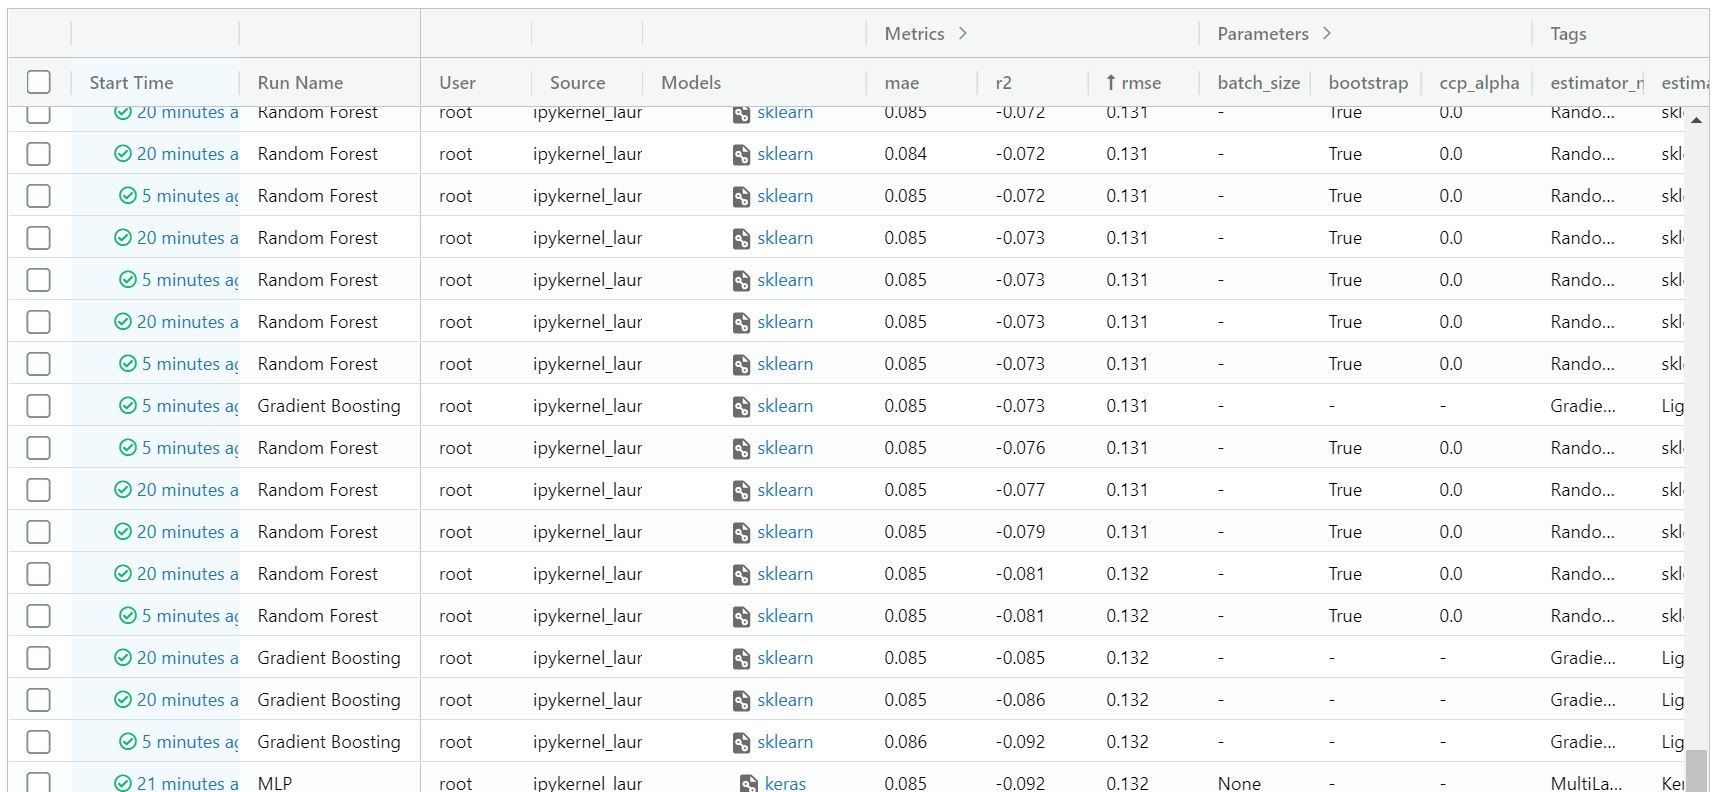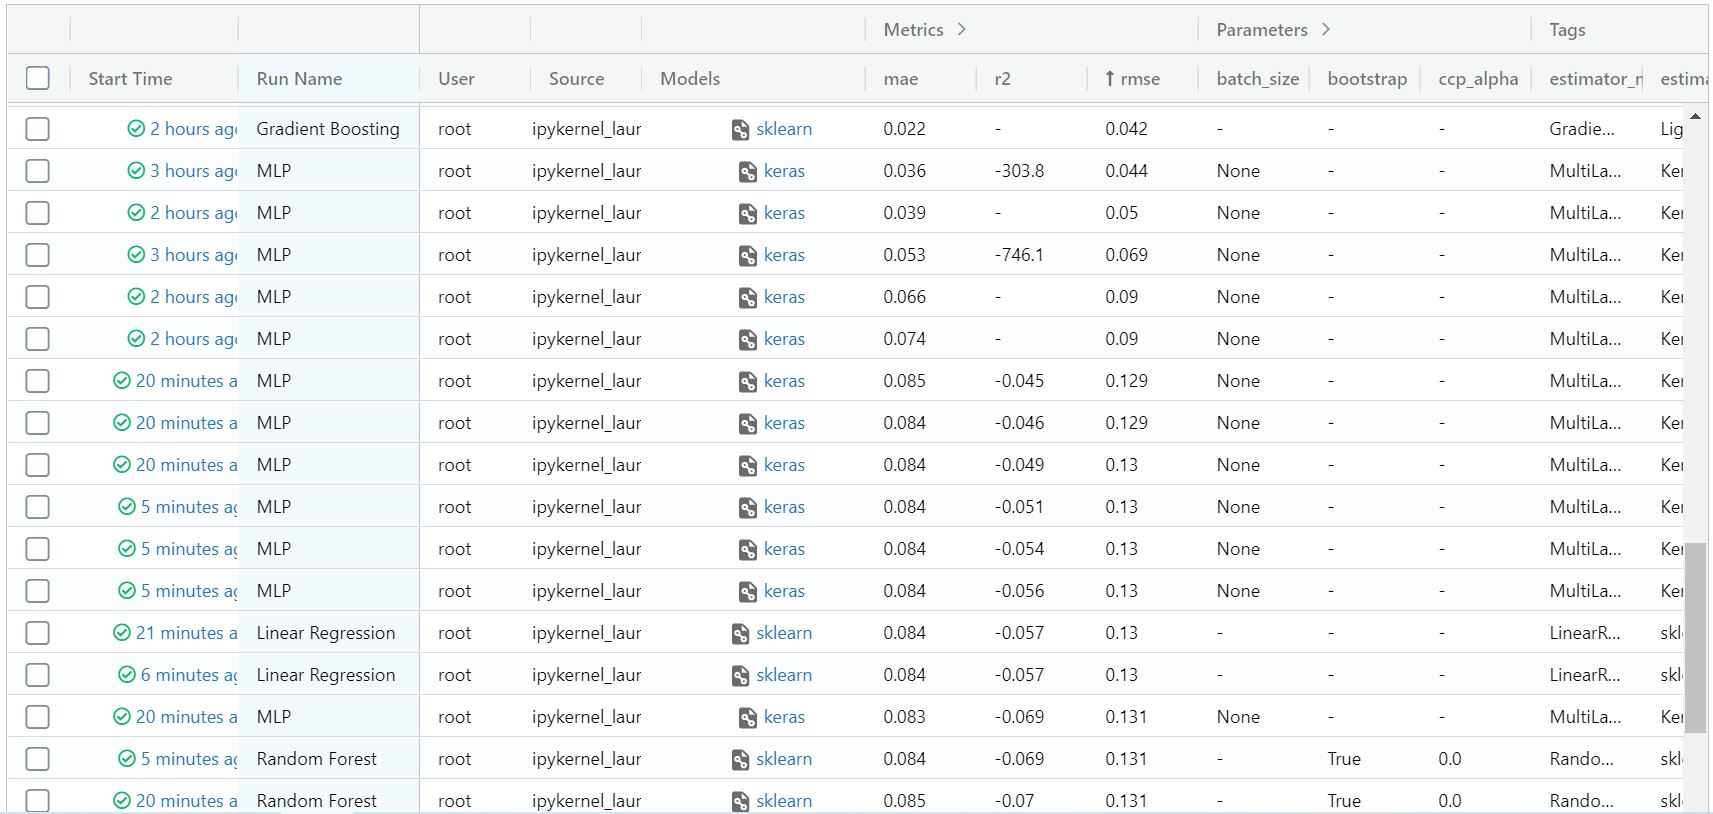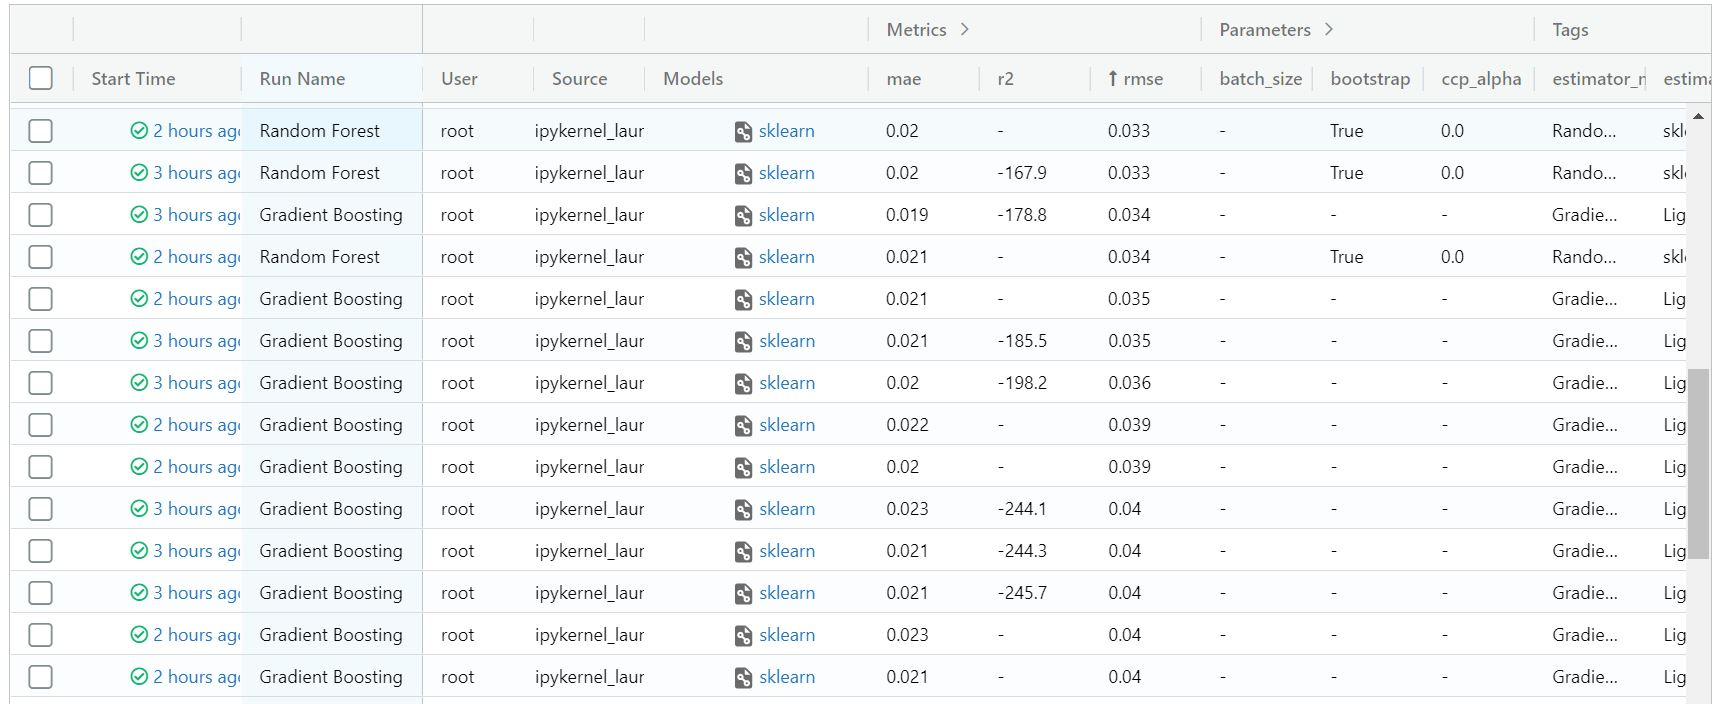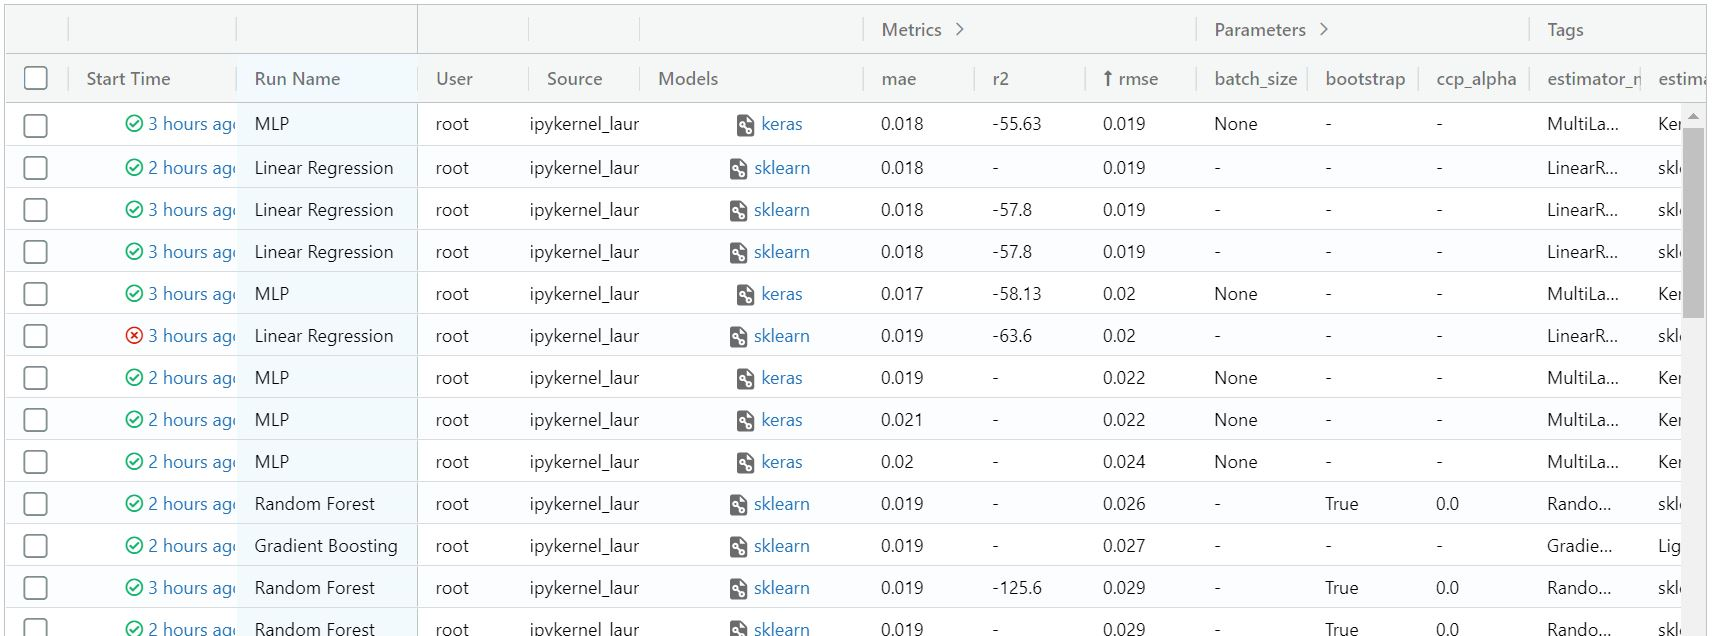

In [ ]:
def linear_regression_test(params):
    train, test, val = get_x_data()
    train_labels, val_labels, test_labels = get_y_data()
    
    warnings.filterwarnings("ignore")
    np.random.seed(40)

    with mlflow.start_run(run_name="Linear Regression"):
        reg = LinearRegression()
        reg.fit(train, train_labels)

        predictions = reg.predict(val)

        (rmse, mae, r2) = eval_metrics(val_labels, predictions)

        print("Modelo de regressão linear")
        print("  RMSE: %s" % rmse)
        print("  MAE: %s" % mae)
        print("  R2: %s" % r2)

        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("r2", r2)
        
        
        gc.collect()
        
        return rmse

In [65]:
def mlp_test(param):
    train, test, val = get_x_data()
    train_labels, val_labels, test_labels = get_y_data()
    
    params = {
        "hidden_units": param["hidden_units"],
        "lr": param["lr"],
        "epochs": param["epochs"]
    }
    
    warnings.filterwarnings("ignore")
    np.random.seed(40)
    
    with mlflow.start_run(run_name="MLP"):
        normalizer = preprocessing.Normalization(axis=-1)
        normalizer.adapt(np.array(train))
        
        mlp_model = tf.keras.Sequential([
            normalizer,
            layers.Dense(units=params["hidden_units"]),
            layers.Dense(units=params["hidden_units"]),
            layers.Dense(units=params["hidden_units"]),
            layers.Dense(units=1),
        ])

        mlp_model.summary()
        
        mlp_model.compile(
            optimizer=tf.optimizers.Adam(learning_rate=params["lr"]),
            loss='mean_squared_error'
        )

        history = mlp_model.fit(
            train, train_labels,
            validation_data=(test, test_labels),
            epochs=params["epochs"]
        )
        
        predictions = mlp_model.predict(val)

        (rmse, mae, r2) = eval_metrics(val_labels, predictions)

        print("MLP model")
        print("  RMSE: %s" % rmse)
        print("  MAE: %s" % mae)
        print("  R2: %s" % r2)

        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("r2", r2)
        mlflow.log_params(params)
        mlflow.set_tags(
            {
                "estimator_name":"MultiLayerPerceptron",
                "estimator_class":"Keras"
            }
        )
        
        tf.keras.backend.clear_session()

        gc.collect()
        
        return rmse

In [66]:
params = {
    "hidden_units": 15,
    "epochs": 15,
    "lr": 0.0005216927434366552
}
rmse_mlp = mlp_test(params)
print(rmse_mlp)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_2 (Normalizati (None, 10)                21        
_________________________________________________________________
dense_8 (Dense)              (None, 15)                165       
_________________________________________________________________
dense_9 (Dense)              (None, 15)                240       
_________________________________________________________________
dense_10 (Dense)             (None, 15)                240       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 16        
Total params: 682
Trainable params: 661
Non-trainable params: 21
_________________________________________________________________
Epoch 1/15
94/94 [==============================] - 1s 4ms/step - loss: 0.4644 - val_loss: 0.1403
Epoch 2/15
94/94 [=====